# Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

# Imports

In [106]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import plotly_express as px
import plotly.graph_objects as go
from IPython.display import Image

In [107]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [108]:
df = pd.read_csv("./data/housing.csv")
display(df.head())
display(df.info())
df.dropna(inplace=True)
display(df.head())
display(df.info())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


None

# Drop Outliers

## House Values

### Distribution of Median House Values before Drop

<Axes: xlabel='median_house_value', ylabel='Count'>

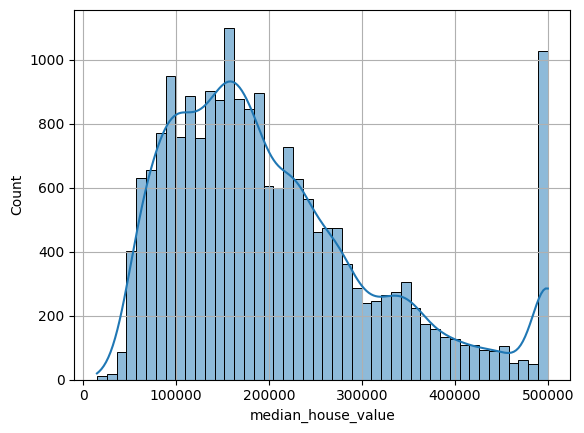

In [109]:
sns.histplot(
    data=df,
    x="median_house_value",
    kde=True,
    palette=sns.color_palette("bright")[:3],
)

### Drop Values >= 500,000

In [110]:
df = df.query("median_house_value < 500e3")

### Distribution of Median House Values after Drop

<Axes: xlabel='median_house_value', ylabel='Count'>

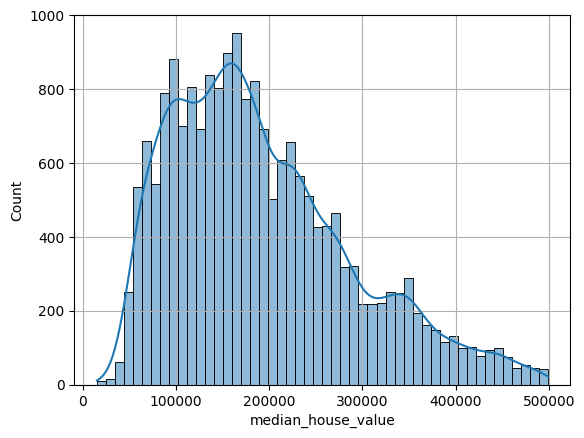

In [111]:
sns.histplot(
    data=df,
    x="median_house_value",
    kde=True,
    palette=sns.color_palette("bright")[:3],
)

## Income

### Distribution of Income before Drop

<Axes: xlabel='median_income', ylabel='Count'>

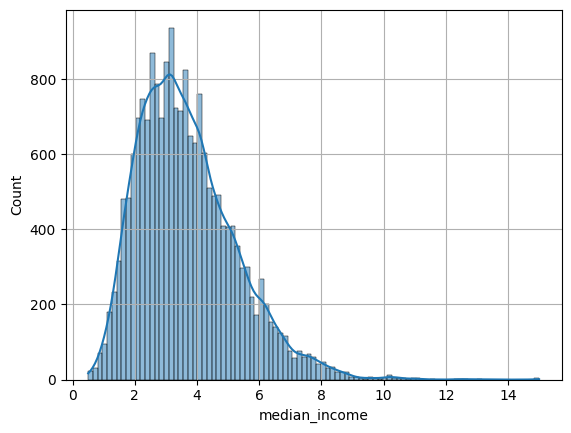

In [112]:
sns.histplot(
    data=df,
    x="median_income",
    kde=True,
    palette=sns.color_palette("bright")[:3],
)

### Drop Values >= 9.0

In [113]:
df = df.query("median_income < 9")

### Distribution of Income After Drop

<Axes: xlabel='median_income', ylabel='Count'>

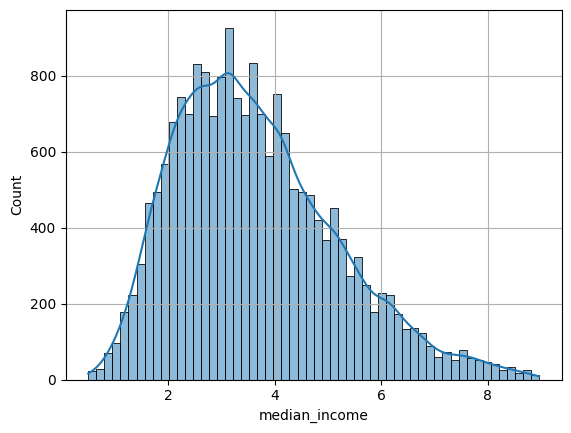

In [114]:
sns.histplot(
    data=df,
    x="median_income",
    kde=True,
    palette=sns.color_palette("bright")[:3],
)

# What Correlates with House Value?

In [115]:
df.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.643178
total_rooms           0.143605
households            0.098119
total_bedrooms        0.078469
housing_median_age    0.074002
population            0.014709
longitude            -0.048331
latitude             -0.148422
Name: median_house_value, dtype: float64

## Joint Plot of Median House Value vs. Income

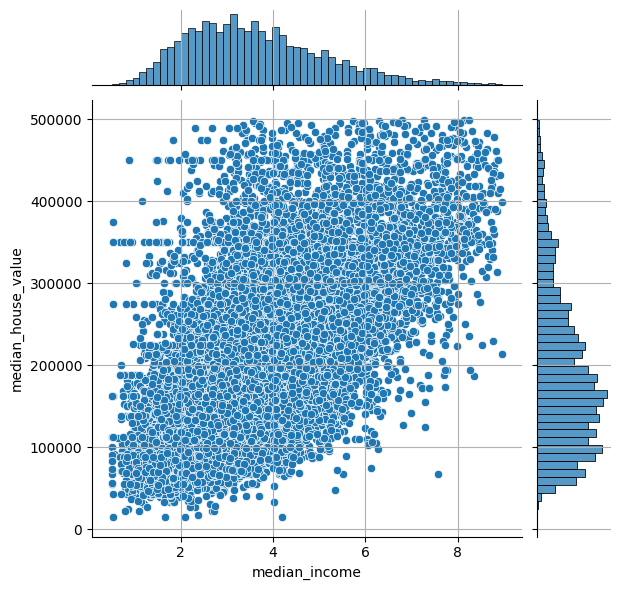

In [116]:
sns.jointplot(df, x="median_income", y="median_house_value")

# Feature Naming

In [156]:
all_features = df.columns.to_list()
target_feature = "median_house_value"
numeric_features = df.columns[df.dtypes != "object"].to_list()
numeric_features.remove(target_feature)
one_hot_features = ["ocean_proximity"]
print(
    "All Features = %s\nTarget Feature = %s\nNumeric Features = %s"
    % (all_features, target_feature, numeric_features)
)

All Features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']
Target Feature = median_house_value
Numeric Features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


# Scale the Data

In [162]:
df_fit = df.drop(columns=target_feature)
df_fit[numeric_features] = StandardScaler().fit_transform(df[numeric_features])
# df_fit[numeric_features] = MinMaxScaler().fit_transform(df[numeric_features])
df_fit.head()
# df_fit.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-1.328542,1.034111,1.008657,-0.796875,-0.973172,-0.978753,-0.979901,3.090450,NEAR BAY
1,-1.323557,1.024813,-0.592004,2.050464,1.338292,0.838043,1.659358,3.074717,NEAR BAY
2,-1.333527,1.020164,1.889020,-0.528120,-0.828854,-0.826698,-0.846895,2.384567,NEAR BAY
3,-1.338513,1.020164,1.889020,-0.616484,-0.722389,-0.772517,-0.737361,1.317413,NEAR BAY
4,-1.338513,1.020164,1.889020,-0.454864,-0.615925,-0.766400,-0.633042,0.129549,NEAR BAY


# Split the Data

75% for training and 25% for development. No holdout set

In [163]:
X_train = df_fit
y_train = df[target_feature]

In [189]:
(X_train, X_dev, y_train, y_dev) = train_test_split(
    df_fit,
    df[target_feature],
    random_state=123,
    test_size=0.25,
)

display([X_train.shape, X_dev.shape])

[(14529, 9), (4844, 9)]

# Baseline Model - 1 Feature

In [195]:
baseline_features = ["median_income"]
baseline_model = LinearRegression(fit_intercept=True).fit(
    X_train[baseline_features], y_train
)

rmse_train = root_mean_squared_error(
    y_train, baseline_model.predict(X_train[baseline_features])
)

rmse_train

73881.52295248772

### Scatter plot of input data and fit

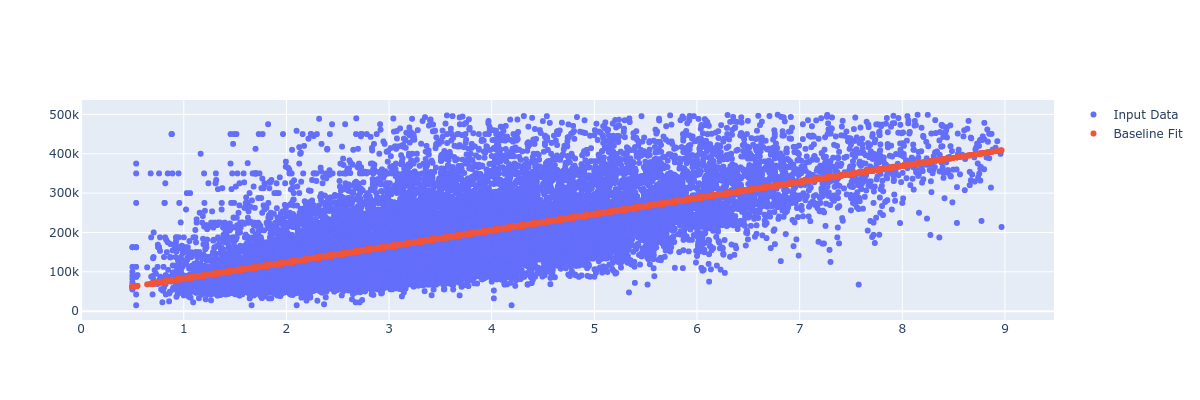

In [186]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df[baseline_features[0]],
        y=df[target_feature],
        mode="markers",
        name="Input Data",
    )
)

fig.add_trace(
    go.Scatter(
        x=df[baseline_features[0]],
        y=baseline_model.predict(df_fit[baseline_features]),
        mode="markers",
        name="Baseline Fit",
    )
)

Image(fig.to_image(format="png", width=1200, height=400, scale=1))

In [159]:
def make_permutation_importance_DataFrame(model, X, features):
    pi = permutation_importance(
        model, X[features], y_train, n_repeats=10, random_state=42
    )
    return pd.DataFrame(
        {
            "Feature": features,
            "Importance": pi.importances_mean,
        }
    )

In [191]:
make_permutation_importance_DataFrame(baseline_model, X_train, baseline_features)

,Feature,Importance
0,median_income,0.820724


# Higher Order Model

In [204]:
high_order_features = [
    "median_income",
    "total_rooms",
    "latitude",
    "longitude",
] + one_hot_features

high_order_features = numeric_features + one_hot_features

degrees = list(range(1, 5))
rmse_train = []
rmse_dev = []
models = []

for degree in degrees:
    xformer = make_column_transformer(
        (
            PolynomialFeatures(degree=degree),
            make_column_selector(dtype_include=np.number),
        ),
        (
            OneHotEncoder(drop="if_binary"),
            one_hot_features,
        ),
    )

    model = Pipeline(
        [
            ("transform", xformer),
            ("regression", LinearRegression(fit_intercept=True)),
        ]
    ).fit(X_train[high_order_features], y_train)

    models.append(model)

    rmse_train.append(
        root_mean_squared_error(y_train, model.predict(X_train[high_order_features]))
    )

    rmse_dev.append(
        root_mean_squared_error(y_dev, model.predict(X_dev[high_order_features]))
    )

    print(
        "Degree = %d, Train RMSE = $%.2f, Dev RMSE = $%.2f"
        % (degree, rmse_train[-1], rmse_dev[-1])
    )

Degree = 1, Train RMSE = $59861.13, Dev RMSE = $59215.14
Degree = 2, Train RMSE = $55101.70, Dev RMSE = $54432.97
Degree = 3, Train RMSE = $52076.34, Dev RMSE = $53757.77
Degree = 4, Train RMSE = $48105.16, Dev RMSE = $70933.02


Text(0.5, 1.0, 'RMSE vs. Polynomial Degree')

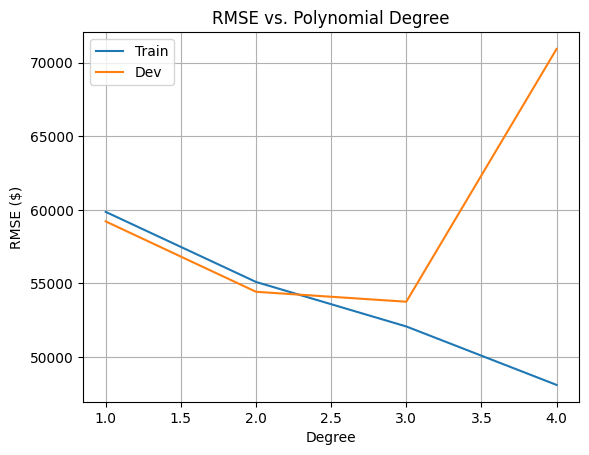

In [203]:
plt.plot(degrees, rmse_train, label="Train")
plt.plot(degrees, rmse_dev, label="Dev")
plt.xlabel("Degree")
plt.ylabel("RMSE ($)")
plt.legend()
plt.title("RMSE vs. Polynomial Degree")

In [206]:
for model in models:
    display(
        [
            model.score(X_train[high_order_features], y_train),
            model.score(X_dev[high_order_features], y_dev),
        ]
    )

[0.6137372528715079, 0.6200725783485519]

[0.6727173636815468, 0.678959924816084]

[0.707669661962231, 0.686875094752915]

[0.7505541367643964, 0.45482994999299287]

In [205]:
make_permutation_importance_DataFrame(models[1], X_train, high_order_features)

,Feature,Importance
0,longitude,1.875188
1,latitude,1.878245
2,housing_median_age,0.089636
3,total_rooms,2.681984
4,total_bedrooms,1.881667
5,population,0.653622
6,households,6.028342
7,median_income,0.875177
8,ocean_proximity,0.044506
